# Phase 1
# Load and Inspect the Dataset

In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve

# Load the dataset
df = pd.read_csv('Fraud.csv')

# Display the first few rows of the dataset
df.head()

# Check dataset information
df.info()

# Check for missing values
df.isnull().sum()

# Check for duplicates
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            500000 non-null  int64  
 1   type            500000 non-null  object 
 2   amount          500000 non-null  float64
 3   nameOrig        500000 non-null  object 
 4   oldbalanceOrg   500000 non-null  float64
 5   newbalanceOrig  500000 non-null  float64
 6   nameDest        500000 non-null  object 
 7   oldbalanceDest  500000 non-null  float64
 8   newbalanceDest  500000 non-null  float64
 9   isFraud         500000 non-null  int64  
 10  isFlaggedFraud  500000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 42.0+ MB


0

    Libraries Imported: The necessary libraries for data manipulation, visualization, and machine learning are imported.

    Dataset Loading: The dataset is loaded from a CSV file named 'Fraud.csv'.

    Dataset Inspection: The first few rows of the dataset are displayed using df.head(). The dataset information is checked using df.info(), and missing values and duplicates are checked using df.isnull().sum() and df.duplicated().sum() respectively.

# Phase 2 
# Exploratory Data Analysis and Feature Engineering

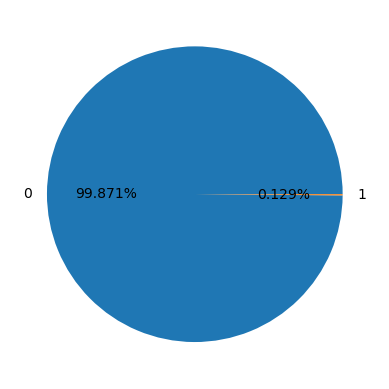

In [24]:
# Visualize the distribution of the target variable 'isFraud'
plt.pie(df["isFraud"].value_counts(), labels=df["isFraud"].unique(), autopct='%1.3f%%')
plt.show()

# Feature engineering: Calculate the amount debited from the payer's account
df["payerdebited"] = df["oldbalanceOrg"] - df["newbalanceOrig"]

# Feature engineering: Calculate the amount credited to the receiver's account
df["recievercredited"] = df["newbalanceDest"] - df["oldbalanceDest"]

# Extract receiver type (Merchant or Customer)
df["reciever_type"] = [i[0:1] for i in df["nameDest"]]

# Extract payer type (Merchant or Customer)
df["payer_type"] = [i[0:1] for i in df["nameOrig"]]

# Convert 'step' to datetime and extract hour, day of the week, and date
df['datetime'] = pd.to_datetime('2025-02-01') + pd.to_timedelta(df['step'], unit='h')
df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['date'] = df['datetime'].dt.day

# Drop unnecessary columns
todrop = ["nameDest", "nameOrig", "oldbalanceOrg", "newbalanceOrig", "newbalanceDest", "oldbalanceDest", "payer_type", "step", "datetime", "isFlaggedFraud"]
df.drop(columns=todrop, inplace=True)

New Features: New features are created:

    payerdebited: The amount debited from the payer's account.

    recievercredited: The amount credited to the receiver's account.

    reciever_type: Extracts the type of receiver (Merchant or Customer).

    payer_type: Extracts the type of payer (Merchant or Customer).

    datetime, hour, day_of_week, date: Extracted from the step column to get temporal features.

Drop Columns: Unnecessary columns are dropped to simplify the dataset

Pie Chart: A pie chart is created to visualize the distribution of the target variable isFraud, which indicates whether a transaction is fraudulent (1) or not (0).

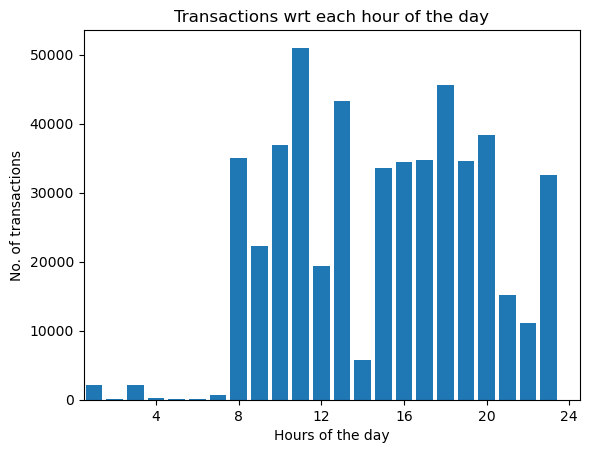

In [25]:
plt.bar(df['hour'].unique(), df['hour'].value_counts())
plt.xlim(0.5, 24.5)
plt.xticks(range(4, 25, 4))
plt.xlabel("Hours of the day")
plt.ylabel("No. of transactions")
plt.title("Transactions wrt each hour of the day")
plt.show()

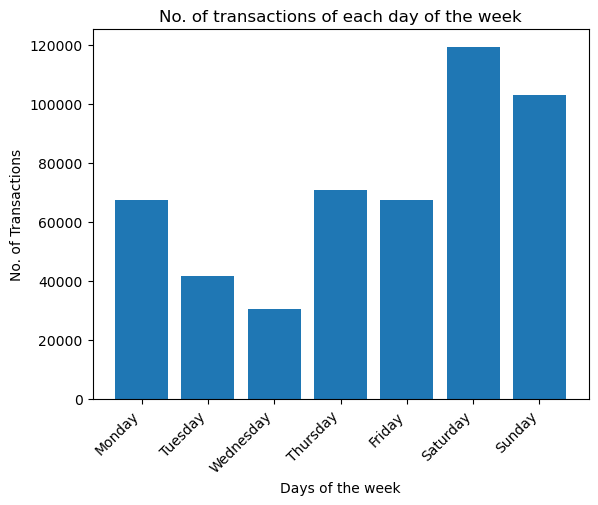

In [26]:
# Map day_of_week integers to day names
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Get the counts for each day of the week, sorted by day (0 to 6)
day_counts = df['day_of_week'].value_counts().sort_index()

# Plot the bar chart
plt.bar(day_names, day_counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Days of the week")
plt.ylabel("No. of Transactions")
plt.title("No. of transactions of each day of the week")
plt.show()

In [27]:
df["type"].value_counts()

type
CASH_OUT    175911
PAYMENT     169397
CASH_IN     109496
TRANSFER     41845
DEBIT         3351
Name: count, dtype: int64

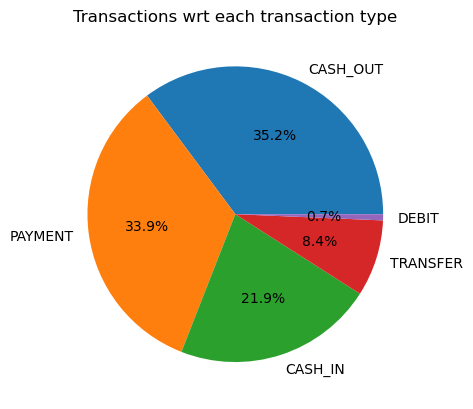

In [28]:
plt.pie(df["type"].value_counts(), labels=df["type"].value_counts().index,autopct='%1.1f%%')
plt.title("Transactions wrt each transaction type")
plt.show()

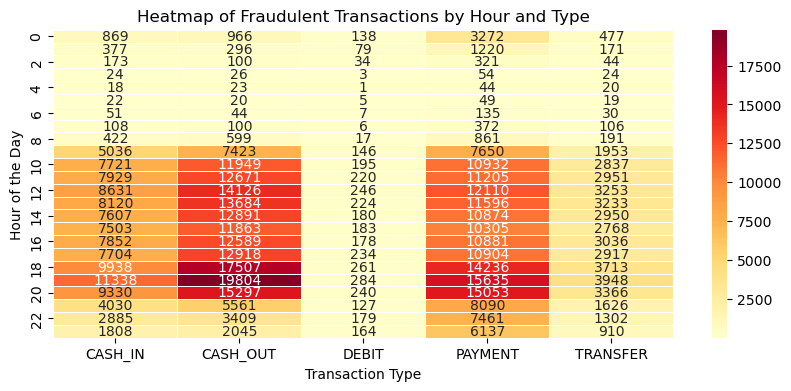

In [29]:
# Create a pivot table for fraudulent transactions
fraud_pivot = df.pivot_table(index='hour', columns='type', values='isFraud', aggfunc='count', fill_value=0)

# Plot heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(fraud_pivot, cmap='YlOrRd', annot=True, fmt='d', linewidths=0.5)
plt.xlabel("Transaction Type")
plt.ylabel("Hour of the Day")
plt.title("Heatmap of Fraudulent Transactions by Hour and Type")
plt.show()

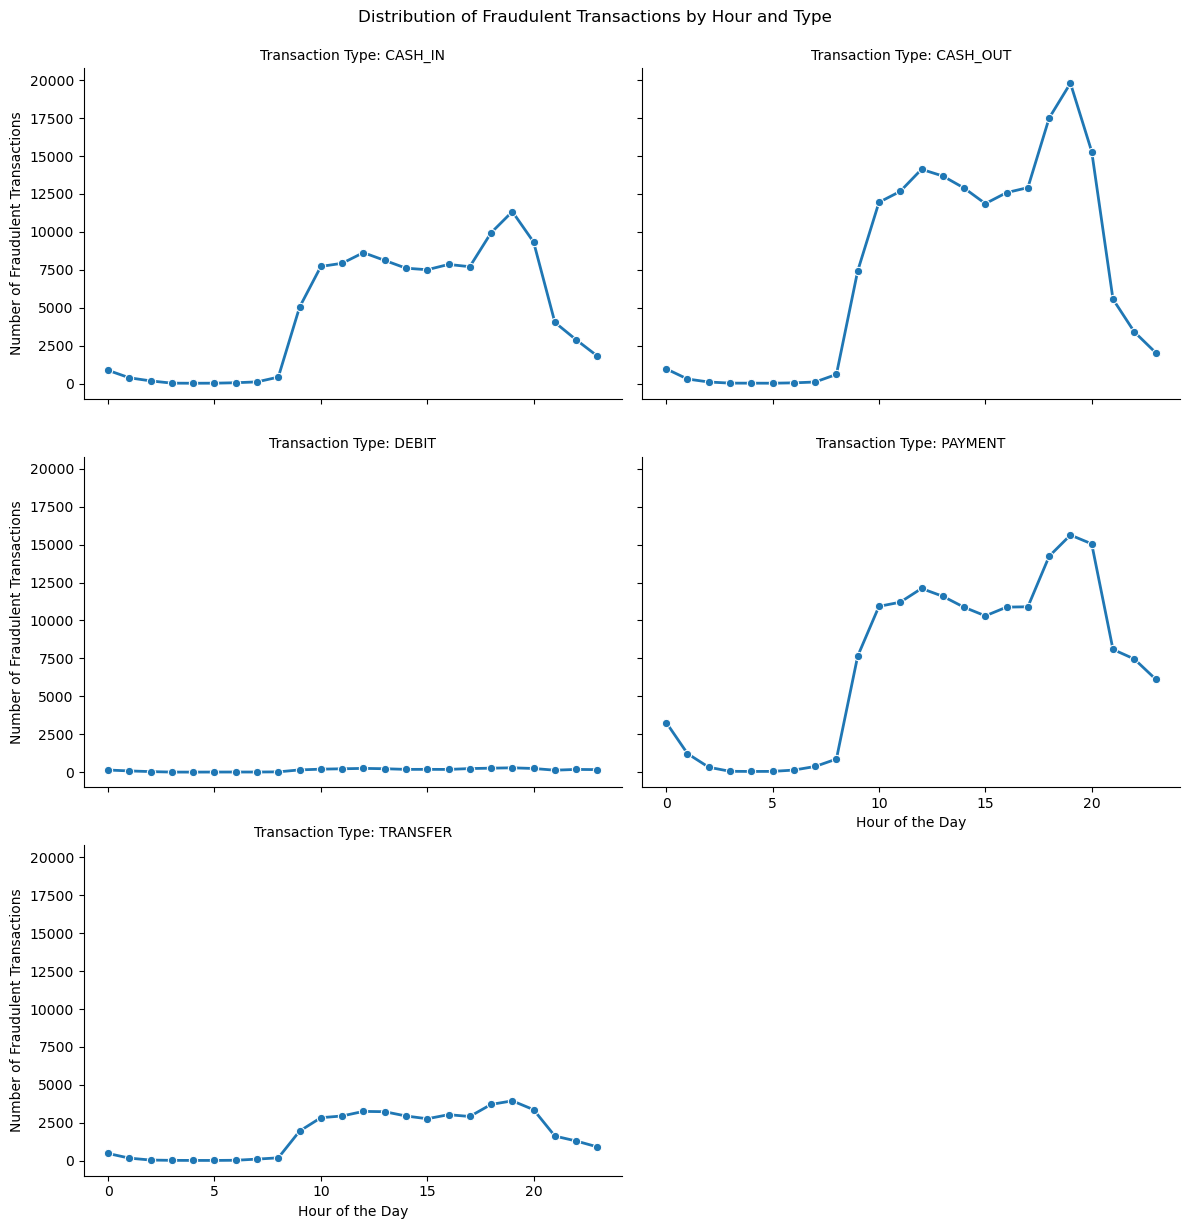

In [30]:
# Filter fraudulent transactions
fraud_df = df[df['isFraud'] == 1]

# Reset the index to make 'hour' a column for seaborn
fraud_pivot = fraud_pivot.reset_index().melt(id_vars='hour', var_name='type', value_name='count')

# Faceted line plot for each transaction type
g = sns.FacetGrid(fraud_pivot, col='type', col_wrap=2, height=4, aspect=1.5)
g.map(sns.lineplot, 'hour', 'count', marker='o', linewidth=2)
g.set_axis_labels("Hour of the Day", "Number of Fraudulent Transactions")
g.set_titles("Transaction Type: {col_name}")
g.fig.suptitle("Distribution of Fraudulent Transactions by Hour and Type", y=1.02)
plt.show()

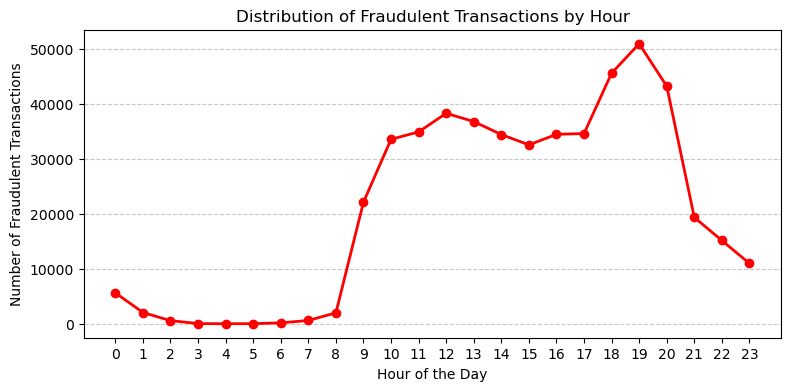

In [31]:
# Filter fraudulent transactions
fraud_df = df[df['isFraud'] == 1]

# Count fraudulent transactions by hour
fraud_by_hour = df['hour'].value_counts().sort_index()

# Plot the distribution of fraudulent transactions by hour (line plot)
plt.figure(figsize=(9, 4))
plt.plot(fraud_by_hour.index, fraud_by_hour.values, marker='o', color='red', linestyle='-', linewidth=2)
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Fraudulent Transactions")
plt.title("Distribution of Fraudulent Transactions by Hour")
plt.xticks(range(0, 24))  # Show all hours on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

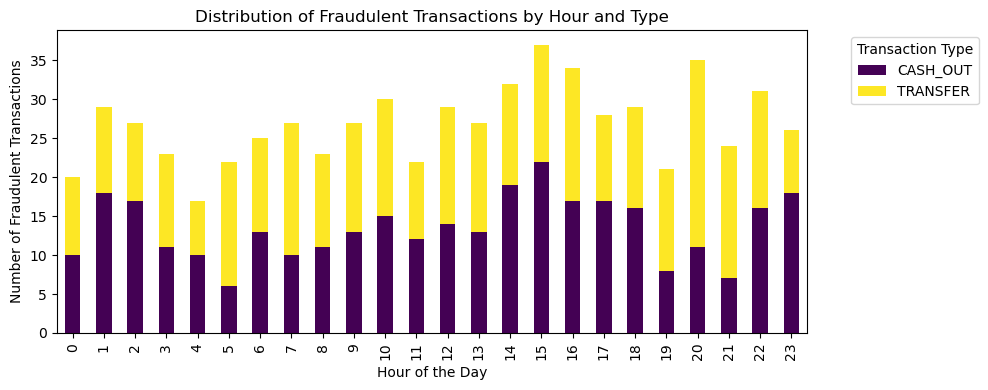

In [32]:
# Group fraudulent transactions by hour and transaction type
fraud_by_hour_type = fraud_df.groupby(['hour', 'type']).size().unstack(fill_value=0)

# Plot the distribution of fraudulent transactions by hour and type
fraud_by_hour_type.plot(kind='bar', stacked=True, figsize=(10, 4), colormap='viridis')
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Fraudulent Transactions")
plt.title("Distribution of Fraudulent Transactions by Hour and Type")
plt.xticks(range(0, 24))  # Show all hours on the x-axis
plt.legend(title="Transaction Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Phase 3
# Balance the Dataset

In [33]:
# Separate the dataset into fraud and non-fraud transactions
fraud = df[df['isFraud'] == 1]
non_fraud = df[df['isFraud'] == 0]

# Downsample the majority class (non-fraud) to match the size of the minority class (fraud)
non_fraud_downsampled = non_fraud.sample(n=len(fraud), random_state=42)

# Combine the downsampled majority class with the minority class
balanced_df = pd.concat([fraud, non_fraud_downsampled])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

Balancing: The dataset is imbalanced with many more non-fraudulent transactions than fraudulent ones. The non-fraudulent transactions are downsampled to match the number of fraudulent transactions, and the dataset is shuffled.

# Phase 4
# Detect and Handle Outliers

In [34]:
# Function to count the number of outliers
def outlier_count(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    upwhisk = Q3 + (IQR * 1.5)
    lowhisk = Q1 - (IQR * 1.5)
    outlier_count = ((data > upwhisk) | (data < lowhisk)).sum()
    return outlier_count

# Count outliers in numeric columns only
outliers = 0
numeric_columns = balanced_df.select_dtypes(include=[np.number]).columns  # Select only numeric columns
for col in numeric_columns:
    outliers += outlier_count(balanced_df[col])
print(f'No of Outliers: {outliers}')

# Create a mask to filter out outliers
outlier_mask = pd.Series(True, index=balanced_df.index)  # Initialize mask with all True values

for col in numeric_columns:
    Q1 = balanced_df[col].quantile(0.25)
    Q3 = balanced_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Update the mask to keep only rows within the bounds for each column
    outlier_mask &= ((balanced_df[col] >= lower_bound) & (balanced_df[col] <= upper_bound))

# Filter the DataFrame to remove outliers
balanced_df_cleaned = balanced_df[outlier_mask]

# Check the shape of the cleaned DataFrame
print(f"Original shape: {balanced_df.shape}")
print(f"Cleaned shape: {balanced_df_cleaned.shape}")

No of Outliers: 595
Original shape: (1290, 9)
Cleaned shape: (995, 9)


Outlier Detection: A function is defined to count outliers using the Interquartile Range (IQR) method. Outliers are counted for all numeric columns in the balanced dataset.

# Phase 5
# Splitting and Training Model

In [35]:
# Encode categorical variables
cat_cols = [col for col in balanced_df.columns if balanced_df[col].dtype == "object"]
encoder = LabelEncoder()
encoded_df = balanced_df.copy()
mappings = {}

for col in cat_cols:
    encoded_df[col] = encoder.fit_transform(balanced_df[col])
    mappings[col] = pd.Series(encoder.transform(encoder.classes_), index=encoder.classes_)

# Split the dataset into training and testing sets
x = encoded_df.drop(columns=["isFraud", "date", "reciever_type", "hour", "day_of_week"])
y = encoded_df['isFraud']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

# Predictions
y_pred = rf_model.predict(x_test)
y_proba = rf_model.predict_proba(x_test)[:, 1]



In [36]:
# Print the mappings for each categorical column
for col, mapping in mappings.items():
    print(f"Mapping for column '{col}':")
    print(mapping)
    print("\n")

Mapping for column 'type':
CASH_IN     0
CASH_OUT    1
DEBIT       2
PAYMENT     3
TRANSFER    4
dtype: int64


Mapping for column 'reciever_type':
C    0
M    1
dtype: int64




    Encoding: Categorical variables are encoded using LabelEncoder.

    Train-Test Split: The dataset is split into training and testing sets.

    Model Training: A Random Forest Classifier is trained on the training data.

    Predictions: Predictions and probabilities are generated for the test set.

# Phase 6
# Performance Evaluation

In [37]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       136
           1       0.94      0.96      0.95       122

    accuracy                           0.95       258
   macro avg       0.95      0.95      0.95       258
weighted avg       0.95      0.95      0.95       258

Confusion Matrix:
[[129   7]
 [  5 117]]


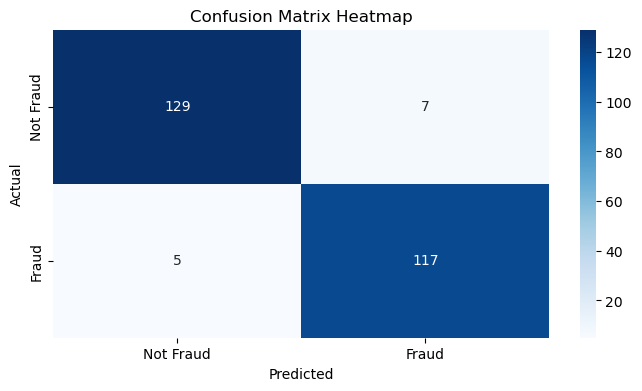

In [38]:
# Confusion Matrix Heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Not Fraud", "Fraud"], 
            yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Heatmap")
plt.show()


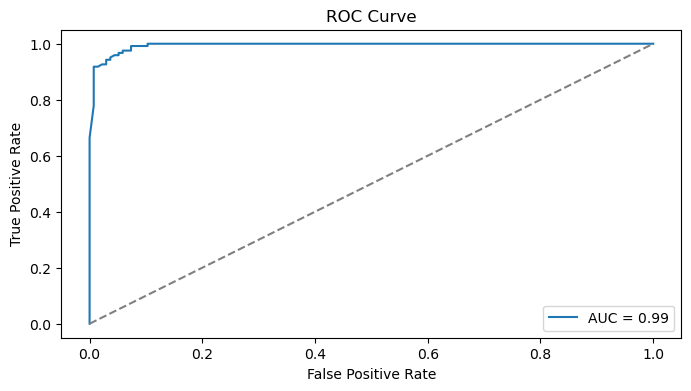

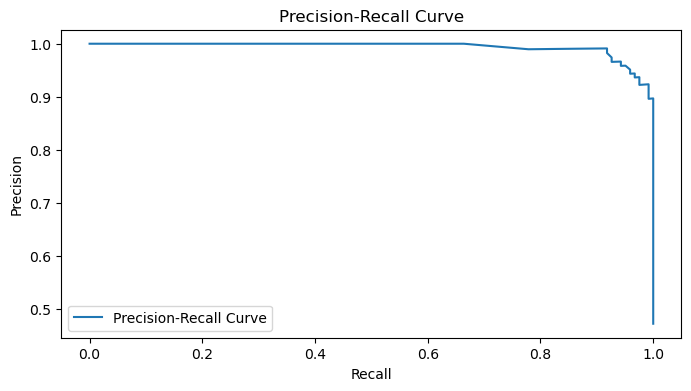

In [39]:
# ROC Curve and AUC Score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 4))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

    Classification Report: The classification report is printed, showing precision, recall, F1-score, and support for each class.

    Confusion Matrix: A heatmap of the confusion matrix is plotted to visualize the model's performance.

    ROC Curve: The ROC curve is plotted to evaluate the model's ability to distinguish between the classes.

# Phase 7
# Feature Importance

In [40]:
# Print the features used for training
print("Features used for training the model:")
print(x.columns.tolist())

# Get feature importances from the trained Random Forest model
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importance
print("\nFeature Importance Scores:")
print(feature_importance_df)

Features used for training the model:
['type', 'amount', 'payerdebited', 'recievercredited']

Feature Importance Scores:
            Feature  Importance
2      payerdebited    0.568513
1            amount    0.169496
3  recievercredited    0.138632
0              type    0.123358


# Phase 8
# Save and Load the Model

In [41]:
import pickle

# Save the trained model
with open("model.pkl", "wb") as file:
    pickle.dump(rf_model, file)

print("Model saved successfully!")

# Load the saved model from the file
with open("model.pkl", "rb") as file:
    loaded_model = pickle.load(file)

print("Model loaded successfully!")

Model saved successfully!
Model loaded successfully!


In [44]:
# Create a sample input for testing
sample_data = {
    'type': [4, 4, 4],  # Different transaction types
    'amount': [1000.0, 50000.0, 200.0],  # Different amounts
    'payerdebited': [500.0, 25000.0, 100.0],  # Different debited amounts
    'recievercredited': [500.0, 25000.0, 100.0]  # Different credited amounts
}

# Convert the sample data into a DataFrame
sample_df = pd.DataFrame(sample_data)

# Ensure the columns are in the correct order (same as during training)
sample_df = sample_df[['type', 'amount', 'payerdebited', 'recievercredited']]

# Make predictions using the loaded model
predictions = loaded_model.predict(sample_df)

# Display the predictions
print("Predictions:", predictions)

# If you want to see the predicted probabilities (for classification)
if hasattr(loaded_model, "predict_proba"):
    probabilities = loaded_model.predict_proba(sample_df)
    print("Predicted Probabilities:", probabilities)

Predictions: [1 1 1]
Predicted Probabilities: [[0.44 0.56]
 [0.19 0.81]
 [0.41 0.59]]
